In [1]:
#import the data reader
import matplotlib.pyplot as plt
from csv import reader
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
#read data from the data storage
crime_data_lines = sc.textFile('/FileStore/tables/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')
#prepare data 
df_crimes = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])
#get header
header = df_crimes.first()
header

Out[ 3 ]: 
['IncidntNum',
 'Category',
 'Descript',
 'DayOfWeek',
 'Date',
 'Time',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'Location',
 'PdId']

In [3]:
#remove the first line of data
crimes = df_crimes.filter(lambda x: x != header)

In [4]:
#get the first line of data
display(crimes.take(2))

_1,_2,_3,_4,_5,_6,_7,_8,_9,_10,_11,_12,_13
150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.42158168137,37.7617007179518,"(37.7617007179518, -122.42158168137)",15006027571000
150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821003074


### how to solove our big data issues
####  approach 1: use RDD 
#### approach 2: use Dataframe, register the RDD to a dataframe
#### approach 3: use SQL

#### We provide 3 options to get distributed data into dataframe and SQL table

#### option 1 to get dataframe and sql

In [8]:

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt1 = spark.read.format("csv").option("header", "true").load("/FileStore/tables/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv")
display(df_opt1.take(5))
df_opt1.createOrReplaceTempView("sf_crime")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.42158168137,37.7617007179518,"(37.7617007179518, -122.42158168137)",15006027571000
150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821003074
150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821004014
150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821015200
150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431118543788,37.8004687042875,"(37.8004687042875, -122.431118543788)",15009822628160


In [9]:
df_opt1[['X','Y']]

Out[ 7 ]: DataFrame[X: string, Y: string]

#### option 2 to get dataframe and sql

In [11]:

from pyspark.sql import Row

def createRow(keys, values):
  assert len(keys) == len(values)
  mapped = dict(zip(keys, values))
  return Row(**mapped)

rdd_rows = crimes.map(lambda x: createRow(header, x))

df_opt2 = spark.createDataFrame(rdd_rows)
#df_opt2.createOrReplaceTempView("sf_crime")
display(df_opt2.take(5))

Address,Category,Date,DayOfWeek,Descript,IncidntNum,Location,PdDistrict,PdId,Resolution,Time,X,Y
18TH ST / VALENCIA ST,NON-CRIMINAL,01/19/2015,Monday,LOST PROPERTY,150060275,"(37.7617007179518, -122.42158168137)",MISSION,15006027571000,NONE,14:00,-122.42158168137,37.7617007179518
300 Block of LEAVENWORTH ST,ROBBERY,02/01/2015,Sunday,"ROBBERY, BODILY FORCE",150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821003074,NONE,15:45,-122.414406029855,37.7841907151119
300 Block of LEAVENWORTH ST,ASSAULT,02/01/2015,Sunday,AGGRAVATED ASSAULT WITH BODILY FORCE,150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821004014,NONE,15:45,-122.414406029855,37.7841907151119
300 Block of LEAVENWORTH ST,SECONDARY CODES,02/01/2015,Sunday,DOMESTIC VIOLENCE,150098210,"(37.7841907151119, -122.414406029855)",TENDERLOIN,15009821015200,NONE,15:45,-122.414406029855,37.7841907151119
LOMBARD ST / LAGUNA ST,VANDALISM,01/27/2015,Tuesday,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",150098226,"(37.8004687042875, -122.431118543788)",NORTHERN,15009822628160,NONE,19:00,-122.431118543788,37.8004687042875


#### option 3 to get dataframe and sql

In [13]:

df_opt3 = crimes.toDF(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId'])
display(df_opt3.take(5))
#df_opt3.createOrReplaceTempView("sf_crime")

IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.42158168137,37.7617007179518,"(37.7617007179518, -122.42158168137)",15006027571000
150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821003074
150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821004014
150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406029855,37.7841907151119,"(37.7841907151119, -122.414406029855)",15009821015200
150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431118543788,37.8004687042875,"(37.8004687042875, -122.431118543788)",15009822628160


##Write a Spark program that counts the number of crimes for different category.

In [15]:
#rdd based
'''
catorgory_set_rdd = crimes.map(lambda item: (item[1],1))
from operator import add
result = sorted(catorgory_set_rdd.reduceByKey(add).collect(), key = lambda item: -item[1])
display(result)
'''


Out[ 10 ]: '\ncatorgory_set_rdd = crimes.map(lambda item: (item[1],1))\nfrom operator import add\nresult = sorted(catorgory_set_rdd.reduceByKey(add).collect(), key = lambda item: -item[1])\ndisplay(result)\n'

In [16]:
#dataframe based
q1_result = df_opt1.groupBy('category').count().orderBy('count', ascending=False)
display(q1_result)

category,count
LARCENY/THEFT,480448
OTHER OFFENSES,309358
NON-CRIMINAL,238323
ASSAULT,194694
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116059
WARRANTS,101379
BURGLARY,91543
SUSPICIOUS OCC,80444


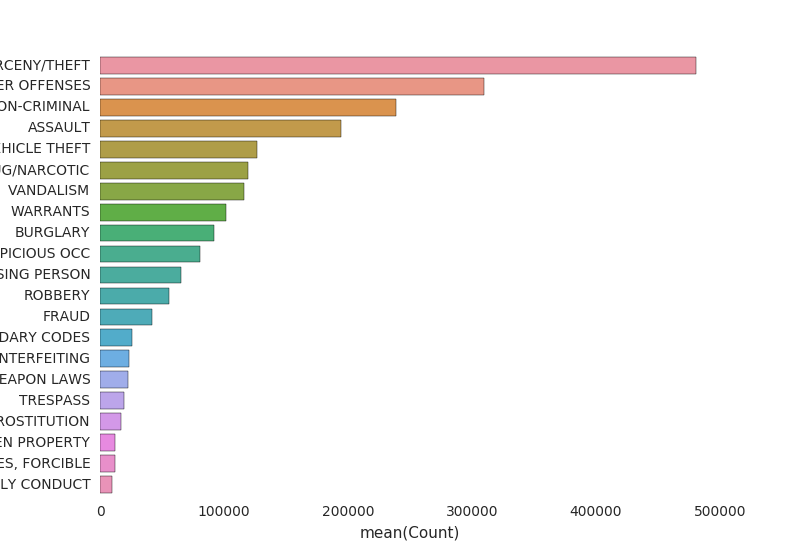

In [17]:
#Spark SQL based
plt.close()
crimeCategory = spark.sql("SELECT category, COUNT(*) AS Count FROM sf_crime GROUP BY category ORDER BY Count DESC").toPandas()
crimeCategory=crimeCategory[crimeCategory['Count']>10000]
ax = sns.barplot(y=crimeCategory['category'], x=crimeCategory['Count'])
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
display(plt.show())


## Write a program that counts the number of crimes for different district

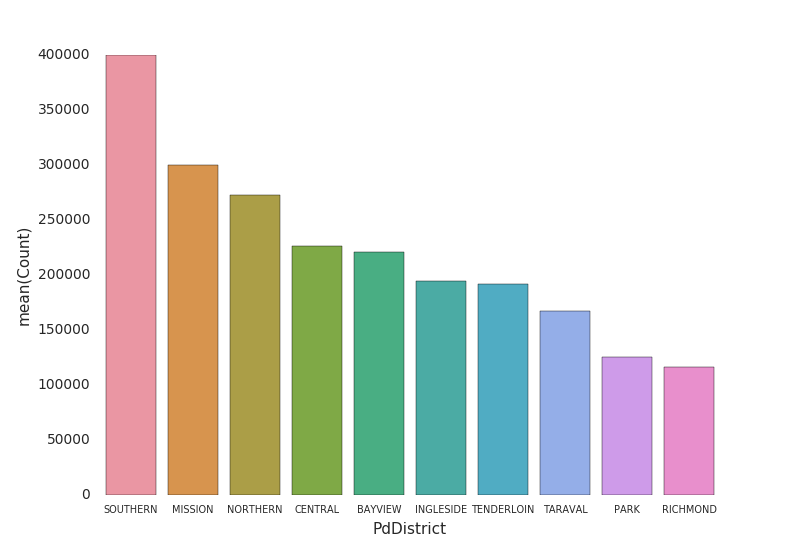

In [19]:
#Spark SQL based
plt.close()
crimeDistrict = spark.sql("SELECT PdDistrict, COUNT(*) AS Count FROM sf_crime GROUP BY PdDistrict ORDER BY Count DESC").toPandas()
ax = sns.barplot(x=crimeDistrict['PdDistrict'], y=crimeDistrict['Count'])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
display(plt.show())


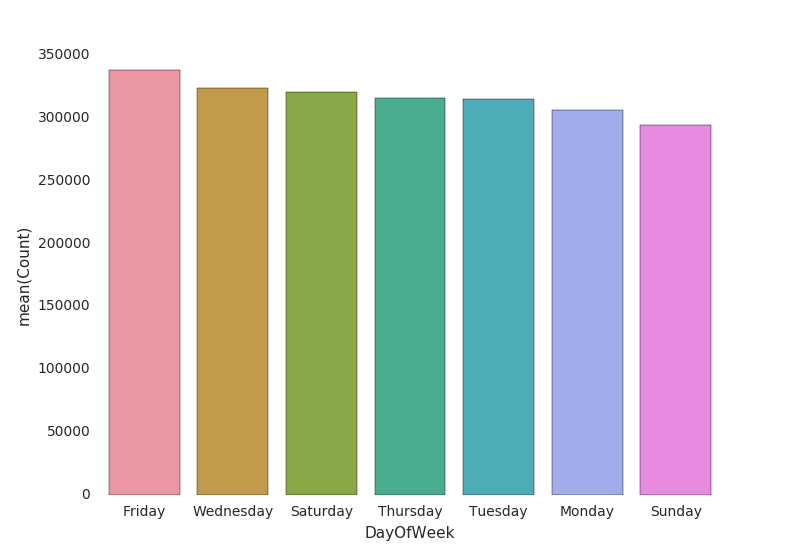

In [20]:
#Spark SQL based
plt.close()
crimeDay = spark.sql("SELECT DayOfWeek, COUNT(*) AS Count FROM sf_crime GROUP BY DayOfWeek ORDER BY Count DESC").toPandas()
ax = sns.barplot(x=crimeDay['DayOfWeek'], y=crimeDay['Count'])
display(plt.show())
plt.close()

In [21]:
time_col=df_opt1[['time']].toPandas()
time_col = pd.DataFrame(time_col.time.str.split(':',1).tolist(),columns = ['hour','minute'])
df_time=time_col['hour'].value_counts()
df_time=df_time.to_frame()
df_time.index.values

Out[ 15 ]: 
array([u'18', u'17', u'12', u'19', u'16', u'15', u'20', u'22', u'00',
 u'14', u'21', u'13', u'23', u'11', u'10', u'09', u'08', u'01',
 u'07', u'02', u'03', u'06', u'04', u'05'], dtype=object)

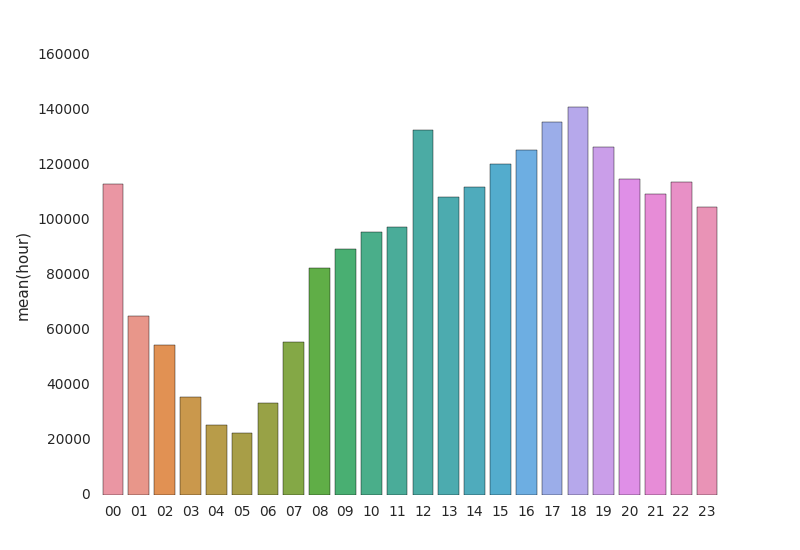

In [22]:
plt.close()
ax = sns.barplot(y=df_time['hour'],x=df_time.index.values)
display(plt.show())

In [23]:
#Spark SQL based
#crimeDay = spark.sql("SELECT DayOfWeek, COUNT(*) AS Count FROM sf_crime GROUP BY DayOfWeek ORDER BY Count DESC")
#display(crimeDay)

## Write a program to count the number of crimes each Sunday at SF downtown.

In [25]:
#Spark SQL based


##visualize the spatial distribution of crimes and run a kmeans clustering algorithm (please use Spark ML kmeans)

In [27]:
pdf = df_opt1[['Y','X']].toPandas()
pdf=pdf.astype(float)
pdf=pdf.loc[(pdf.X<= -122.32) & (pdf.X>= -122.53)]
pdf

Out[ 24 ]: 
 Y X
0 37.761701 -122.421582
1 37.784191 -122.414406
2 37.784191 -122.414406
3 37.784191 -122.414406
4 37.800469 -122.431119
5 37.787085 -122.451782
6 37.729203 -122.374019
7 37.729203 -122.374019
8 37.787809 -122.406568
9 37.786258 -122.417295
10 37.769075 -122.413354
11 37.769075 -122.413354
12 37.769075 -122.413354
13 37.769075 -122.413354
14 37.765111 -122.432198
15 37.781753 -122.422277
16 37.781753 -122.422277
17 37.742260 -122.387939
18 37.767200 -122.458639
19 37.735227 -122.389775
20 37.796903 -122.406832
21 37.796903 -122.406832
22 37.751525 -122.405252
23 37.796903 -122.406832
24 37.796903 -122.406832
25 37.784697 -122.413609
26 37.784697 -122.413609
27 37.784697 -122.413609
28 37.760493 -122.388559
29 37.778719 -122.414744
... ... ...
2214994 37.775333 -122.397208
2214995 37.762979 -122.491605
2214996 37.745653 -122.461583
2214997 37.777624 -122.399981
2214998 37.784697 -122.413609
2214999 37.771428 -122.453982
2215000 37.796626 -122.401857
2215001 37.790673 -122.412269
2215002 37.788275 -122.406659
2215003 37.773732 -122.447689
2215004 37.807891 -122.410691
2215005 37.775871 -122.406842
2215006 37.790366 -122.407152
2215007 37.769798 -122.448578
2215008 37.799706 -122.412069
2215009 37.783992 -122.408068
2215010 37.775421 -122.403405
2215011 37.725844 -122.478885
2215012 37.723336 -122.475306
2215013 37.723336 -122.475306
2215014 37.723336 -122.475306
2215015 37.750674 -122.417730
2215016 37.752104 -122.420666
2215017 37.773414 -122.419184
2215018 37.782371 -122.448043
2215019 37.782585 -122.415695
2215020 37.766246 -122.410478
2215021 37.784479 -122.404270
2215022 37.775553 -122.440483
2215023 37.782843 -122.413238

[2214881 rows x 2 columns]

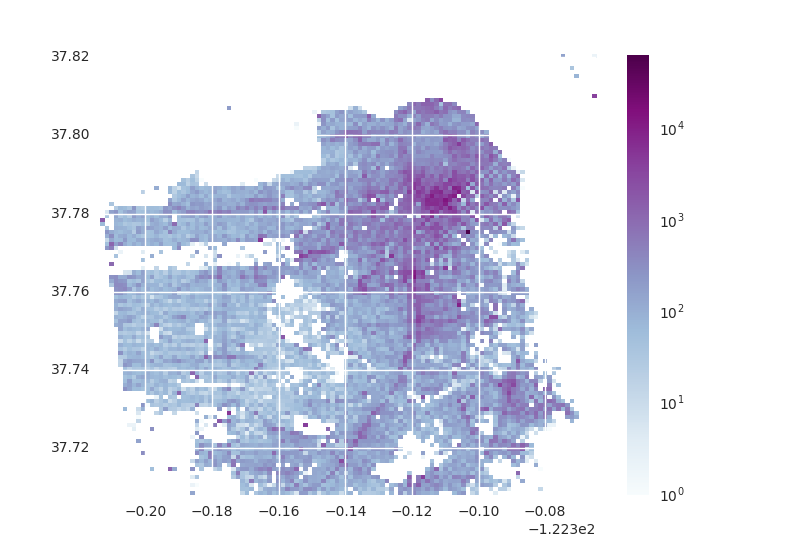

In [28]:
import matplotlib as mpl
plt.close()


plt.hist2d(x=pdf.X, y=pdf.Y, norm=mpl.colors.LogNorm(), bins=(110, 110), cmap=plt.cm.BuPu)
plt.colorbar()

'''
aw=pdf.plot(kind='scatter', x='X', y='Y',title='Crimes Spatial Distribution',c='yellow',alpha=0.01,s=1)
aw.set_xlabel('Lontitute')
aw.set_ylabel('Latitute')
'''

display(plt.show())


###cast longitutue and latitute to float, and prepare feature dataset to train Kmeans

In [30]:
pdf = pdf.sample(frac=0.05)
df_test = spark.createDataFrame(pdf)
#df_opt1 = df_opt1.withColumn('X', df_opt1['X'].cast('float')).withColumn('Y', df_opt1['Y'].cast('float'))
#df_filter=df_opt1.filter((df_opt1["X"]>=-122.53) & (df_opt1["X"]<=-122.32) & (df_opt1["Y"]>=37.705) & (df_opt1["Y"]<=37.81))
vecAssembler = VectorAssembler(inputCols=["X", "Y"], outputCol="features")
new_df = vecAssembler.transform(df_test)[['features']]
new_df.show()

+--------------------+
 features|
+--------------------+
[-122.43248331953...|
[-122.40545578922...|
[-122.42752326450...|
[-122.44151299120...|
[-122.41591119887...|
[-122.42372128398...|
[-122.40623501120...|
[-122.51364206426...|
[-122.41203235978...|
[-122.38792738760...|
[-122.39998111124...|
[-122.44577373442...|
[-122.41694087461...|
[-122.40340479147...|
[-122.42140808106...|
[-122.47797668216...|
[-122.39221732553...|
[-122.40097665682...|
[-122.40925609649...|
[-122.41762831134...|
+--------------------+
only showing top 20 rows

###Train the model

In [32]:
kmeans = KMeans().setK(3)
model = kmeans.fit(new_df)


###label the color of plots

In [34]:
centers = model.clusterCenters()
long_centers = [i for i, _ in centers]
lat_centers = [i for _, i in centers]
transformed = model.transform(new_df)
memberships = transformed.toPandas().loc[:,'prediction'].values
clusters2colors = {0: '#96f97b', 1: '#ff000d', 2: '#02d8e9'}
colors = [clusters2colors[i] for i in memberships]

### visulize the result

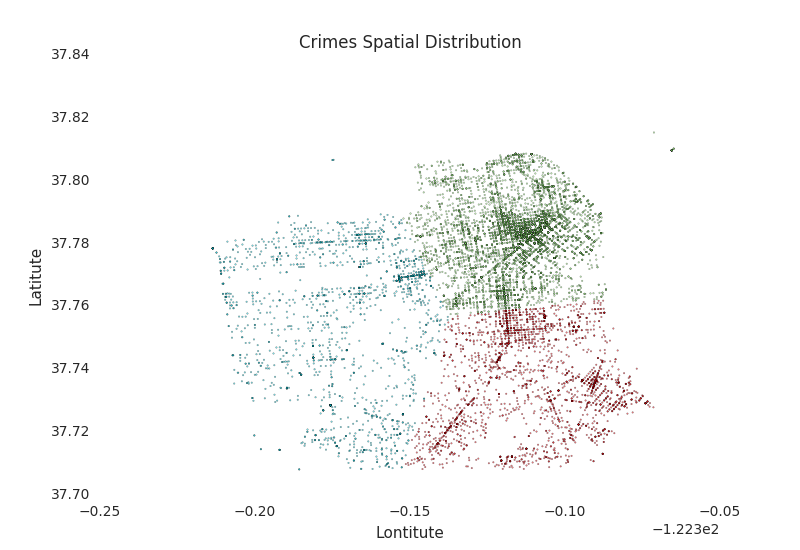

In [36]:
#plot the spatial Distribution
aw=pdf.plot(kind='scatter', x='X', y='Y',title='Crimes Spatial Distribution',c=colors,alpha=0.5,s=1.2)
aw.set_xlabel('Lontitute')
aw.set_ylabel('Latitute')
display(plt.show())